# Bandgap prediction using Element Fraction Data
This notebook uses Element Fraction data in order to predict bandgaps of certain compositions
Following the Ward 2016 paper, this notebook provides machine learning techniques trained on composition attributes 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools
import pandas as pd
import matminer
import sys
#sys.path.append("/Users/Ashwin/Desktop/git/matminer")
from pymatgen import Composition, Element
from matminer.descriptors.composition_features import ElementFractionAttribute
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
import datetime
from sklearn.multiclass import OneVsRestClassifier
%matplotlib inline


In [2]:
training_file = "data/oqmd_all.csv"

# Load training data from oqmd database

In [3]:
training_set = pd.read_csv(training_file, delim_whitespace=True, na_values=['None', np.inf])
training_set.head()

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability
0,Li1,-1.892002,17.8351,NaN,0.000,0.004605,0.004605
1,Mg1,-1.539604,22.9639,NaN,0.000,0.002719,0.002719
2,Kr1,0.011256,41.4146,NaN,7.367,0.015315,0.015315
3,Na1,-1.299101,32.9826,NaN,0.000,0.003780,0.003780
4,Pd1,-5.158533,15.2088,NaN,0.000,0.018186,0.018186


In [4]:
comp_objects = [Composition(comp) for comp in training_set["comp"]]
training_set = training_set.assign(comp_obj=comp_objects)
training_set.head()

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,comp_obj
0,Li1,-1.892002,17.8351,NaN,0.000,0.004605,0.004605,(Li)
1,Mg1,-1.539604,22.9639,NaN,0.000,0.002719,0.002719,(Mg)
2,Kr1,0.011256,41.4146,NaN,7.367,0.015315,0.015315,(Kr)
3,Na1,-1.299101,32.9826,NaN,0.000,0.003780,0.003780,(Na)
4,Pd1,-5.158533,15.2088,NaN,0.000,0.018186,0.018186,(Pd)


In [5]:
min_value = min(np.array(training_set['energy_pa'], dtype=float))
#Replace outlier values
training_set = training_set.replace(str(min_value), np.nan)
training_set.dropna(inplace=True)

In [6]:
training_set['is_groundstate'] = False
training_set.shape

(173910, 9)

# Get all groundstate values for each compound
Sort by energy_pa : for repeated compounds, only keep lowest energy state

In [7]:
%%time
for gid, group in training_set.groupby('comp'):
    if group.shape[0] > 1:
        group = group.sort_values('energy_pa', ascending=True)    
    training_set.loc[group.iloc[0].name, 'is_groundstate'] = True
    
    #training_set.iloc[group.energy_pa.idxmin(axis=1)]['is_groundstate']= True
    #print("break")
    #print(training_set.iloc[group.energy_pa.idxmin(axis=1)])
    #training_set.iloc[group.energy_pa.idxmin(axis=1)]['is_groundstate'] = True

CPU times: user 2min 10s, sys: 2.11 s, total: 2min 12s
Wall time: 2min 16s


In [8]:
original_count = len(training_set)
training_set = training_set[training_set['is_groundstate']]
removed = original_count - len(training_set)
print("Removed", removed, "/", original_count)

Removed 50279 / 173910


# Compute descriptors using MatMiner

In [9]:
def calc_attributes(training_set):
    training_set_updated = ElementFractionAttribute().featurize_dataframe(training_set, col_id="comp_obj")
    return training_set_updated
training_set_bg = calc_attributes(training_set)
training_set_bg.shape

(123631, 112)

In [10]:
# Actual bandgap for regression step
bandgaps = np.array(training_set_bg["bandgap"], dtype=float)
#Round to integer values for classification step
bg_range = np.zeros(np.shape(bandgaps), dtype=str)
for i in range(len(bandgaps)):
    if bandgaps[i] == 0:
        bg_range[i] = "0"
    elif bandgaps[i] > 0 and bandgaps[i] < 1.5:
        bg_range[i] = "1"
    elif bandgaps[i] >= 1.5 and bandgaps[i] < 3.0:
        bg_range[i] = "2"
    elif bandgaps[i] >= 3.0:
        bg_range[i] = "3"

In [11]:
#drop default columns
cols_to_drop = ['comp','comp_obj', 'energy_pa', 'volume_pa', 'magmom_pa', 'bandgap', 'delta_e', 'stability', 'is_groundstate']

# Predict Bandgaps 
### Random Forest Classifier

In [24]:
rfc = RandomForestClassifier(n_estimators=10, criterion="gini", min_samples_split=2)
rfc.fit(training_set_bg.drop(cols_to_drop, axis=1), bg_range)
rfc_prediction = rfc.predict(training_set_bg.drop(cols_to_drop, axis=1))

In [25]:
pd.crosstab(bg_range, rfc_prediction, rownames=['actual'], colnames=['predicted'])

predicted,0,1,2,3
actual,,,,
0,118317,7,3,1
1,167,2059,6,0
2,58,9,1814,2
3,32,2,6,1148


### Decision Tree Classifier

In [26]:
dtc = DecisionTreeClassifier()
dtc.fit(training_set_bg.drop(cols_to_drop, axis=1), bg_range)
dtc_prediction = dtc.predict(training_set_bg.drop(cols_to_drop, axis=1))

In [27]:
pd.crosstab(bg_range, dtc_prediction, rownames=['actual'], colnames=['predicted'])

predicted,0,1,2,3
actual,,,,
0,118328,0,0,0
1,0,2232,0,0
2,0,0,1883,0
3,0,0,0,1188


### Random Forest Regressor

In [28]:
rf_model = RandomForestRegressor(n_estimators=100, n_jobs = -1)
rf_model.fit(training_set_bg.drop(cols_to_drop, axis=1), bandgaps)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [29]:
rf_prediction = rf_model.predict(training_set_bg.drop(cols_to_drop, axis=1))

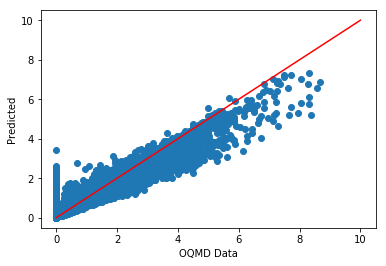

In [30]:
plt.scatter(bandgaps, rf_prediction)
plt.plot(range(11), range(11), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

### Random Forest Regressor Error

In [31]:
import time
#Find error in RandomForestRegressor
cv_start = time.time()

errors = cross_val_score(RandomForestRegressor(), training_set_bg.drop(cols_to_drop, axis=1), bandgaps, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print(mae)
cv_time = time.time()-cv_start
print("Cross-validation time: ", cv_time)


0.0856081596774
Cross-validation time:  170.6775770187378


### Decision Tree Regressor

In [32]:
dt_model = DecisionTreeRegressor()
dt_model.fit(training_set_bg.drop(cols_to_drop, axis=1), bandgaps)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [33]:
dt_prediction = dt_model.predict(training_set_bg.drop(cols_to_drop, axis=1))

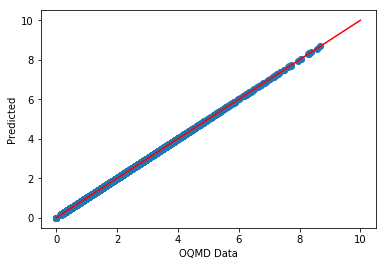

In [34]:
plt.scatter(bandgaps, dt_prediction)
plt.plot(range(11), range(11), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

### Support Vector Classification 80/20 split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(training_set_bg.drop(cols_to_drop, axis=1), bg_range, test_size=0.2, random_state=0)

In [17]:
n_estimators = 10
clf = OneVsRestClassifier(BaggingClassifier(svm.SVC(kernel='linear', probability=True), max_samples=1.0 / n_estimators, n_estimators=n_estimators))

CPU times: user 172 µs, sys: 635 µs, total: 807 µs
Wall time: 815 µs


In [21]:
%%time
clf.fit(X_train, y_train)
print(clf.score(X_test,y_test))

0.956323047681
CPU times: user 5min 10s, sys: 4.77 s, total: 5min 15s
Wall time: 5min 21s


### KFold Cross Validation

In [22]:
%%time
scores = cross_val_score(clf, training_set_bg.drop(cols_to_drop, axis=1), bg_range, cv=3)

CPU times: user 13min 7s, sys: 14.2 s, total: 13min 21s
Wall time: 13min 37s


In [23]:
print("Accuracy %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Accuracy 0.96 (+/- 0.00)


# Predict Formation Energy

In [35]:
training_set_epa = training_set_bg
training_set_epa.head()

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,comp_obj,is_groundstate,Ac,...,Tl,Tm,U,V,W,Xe,Y,Yb,Zn,Zr
69,V1,-8.940979,13.1686,0.002313,0.0,0.000000,0.000000,(V),True,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
74,Rh1,-7.269405,13.9855,-0.014167,0.0,0.000000,0.000000,(Rh),True,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,Ir1,-8.854920,14.4652,0.003235,0.0,0.000000,0.000000,(Ir),True,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90,Pt1,-6.055760,15.5403,0.021855,0.0,0.000000,0.000000,(Pt),True,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,Sm1Zn1,-3.317846,23.9356,0.015790,0.0,-0.327448,-0.044983,"(Sm, Zn)",True,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0


In [36]:
# Remove Outliers
min_value = training_set_epa.min().delta_e
training_set_epa.replace((min_value), np.nan, inplace=True)
training_set_epa.dropna(inplace=True)

In [37]:
#Descretize into pos/neg formation energy

delta_e = np.array(training_set_epa['delta_e'], dtype=float)
#will hold pos/neg for each element in delta_e
energy_range = np.zeros(np.shape(delta_e), dtype=str)
for i in range(len(delta_e)):
    if delta_e[i] < 0:
        energy_range[i] = 'neg'
    else:
        energy_range[i] = 'pos'
energy_range

array(['p', 'p', 'p', ..., 'n', 'n', 'n'], 
      dtype='<U1')

In [38]:
training_set_epa.drop('bandgap', axis=1).isnull().values.any()

False

### Random Forest Classifier

In [39]:
#Random Forest Classifier

rfc = RandomForestClassifier(n_estimators=10, criterion='gini', min_samples_split=2)
rfc.fit(training_set_epa.drop(cols_to_drop, axis=1), energy_range)
rfc_prediction = rfc.predict(training_set_epa.drop(cols_to_drop, axis=1))

In [40]:
pd.crosstab(energy_range, rfc_prediction, rownames=['actual'], colnames=['predicted'])

predicted,n,p
actual,,
n,39390,209
p,284,83747


### Decision Tree Classifier

In [41]:
dtc = DecisionTreeClassifier()
dtc.fit(training_set_epa.drop(cols_to_drop, axis=1), energy_range)
dtc_prediction = dtc.predict(training_set_epa.drop(cols_to_drop, axis=1))

In [42]:
pd.crosstab(energy_range, dtc_prediction, rownames=['actual'], colnames=['predicted'])

predicted,n,p
actual,,
n,39599,0
p,0,84031


### Random Forest Regressor

In [43]:
rf_model = RandomForestRegressor(n_jobs=1)
print(np.shape(training_set_epa))
print(np.shape(delta_e))
rf_model.fit(training_set_epa.drop(cols_to_drop, axis=1), delta_e)
rf_prediction = rf_model.predict(training_set_epa.drop(cols_to_drop, axis=1))

(123630, 112)
(123630,)


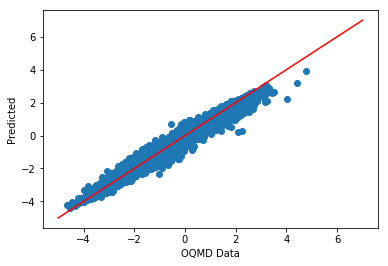

In [44]:
plt.scatter(delta_e, rf_prediction)
plt.plot(range(-5, 8), range(-5, 8), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

### Random Forest Regressor Error

In [45]:
cv_start = time.time()
errors = cross_val_score(RandomForestRegressor(), training_set_epa.drop(cols_to_drop, axis=1),delta_e, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print(mae)
cv_time = time.time() - cv_start
print("Cross-validation time: ", cv_time)

0.271723683382
Cross-validation time:  257.2421519756317


### Decision Tree Regressor

In [46]:
dt_model = DecisionTreeRegressor()
dt_model.fit(training_set_epa.drop(cols_to_drop, axis=1), delta_e)
dt_prediction = dt_model.predict(training_set_epa.drop(cols_to_drop, axis=1))

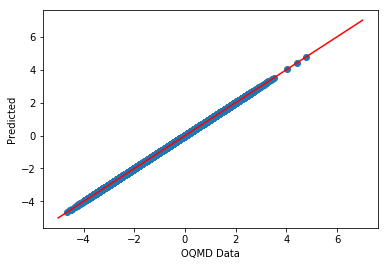

In [47]:
plt.scatter(delta_e, dt_prediction)
plt.plot(range(-5, 8), range(-5, 8), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

### Support Vector Classification 80/20 split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(training_set_epa.drop(cols_to_drop, axis=1), energy_range, test_size=0.2, random_state = 0)

In [49]:
n_estimators = 10
clf = OneVsRestClassifier(BaggingClassifier(svm.SVC(kernel='linear', probability=True), max_samples=1.0 / n_estimators, n_estimators=n_estimators))

In [50]:
%%time
clf.fit(X_train, y_train)
print(clf.score(X_test,y_test))

0.844253013023
CPU times: user 9min 45s, sys: 5.81 s, total: 9min 51s
Wall time: 9min 56s


### KFold Cross Validation

In [70]:
%%time
scores = cross_val_score(clf, training_set_bg.drop(cols_to_drop, axis=1), energy_range, cv=3)

CPU times: user 24min 5s, sys: 19.8 s, total: 24min 25s
Wall time: 24min 54s


In [71]:
print("Accuracy %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Accuracy 0.78 (+/- 0.05)


# Predicting Volume per Atom

In [72]:
#Remove outliers
max_value = max(np.array(training_set_bg['volume_pa'], dtype=float))
training_set_vol = training_set_bg.replace(str(max_value), np.nan)

In [73]:
training_set_vol.dropna(inplace=True)

In [74]:
# Actual volume values for regression
volume_pa = np.array(training_set_vol['volume_pa'], dtype=float)
# Classified volume values for classifiers
vol_range = np.zeros(np.shape(volume_pa), dtype=str)
for i in range(len(volume_pa)):
    if volume_pa[i] < 20:
        vol_range[i] = "0"
    elif volume_pa[i] >= 20 and volume_pa[i] < 40:
        vol_range[i] = '1'
    elif volume_pa[i] >= 40 and volume_pa[i] < 60:
        vol_range[i] = '2'
    elif volume_pa[i] >= 60:
        vol_range[i] = '3'

### Random Forest Classifier

In [75]:
rfc = RandomForestClassifier(n_estimators=10, criterion='gini', min_samples_split=2, n_jobs=-1)
rfc.fit(training_set_vol.drop(cols_to_drop, axis=1), vol_range)
rfc_prediction = rfc.predict(training_set_vol.drop(cols_to_drop, axis=1))


In [76]:
pd.crosstab(vol_range, rfc_prediction, rownames=['actual'], colnames=['predicted'])

predicted,0,1,2,3
actual,,,,
0,54468,146,0,0
1,488,64687,7,0
2,0,131,3499,1
3,0,0,10,193


### Decision Tree Classifier

In [77]:
dtc = DecisionTreeClassifier()
dtc.fit(training_set_vol.drop(cols_to_drop, axis=1), vol_range)
dtc_prediction = dtc.predict(training_set_vol.drop(cols_to_drop, axis=1))

In [78]:
pd.crosstab(vol_range, dtc_prediction, rownames=['actual'], colnames=['predicted'])

predicted,0,1,2,3
actual,,,,
0,54614,0,0,0
1,0,65182,0,0
2,0,0,3631,0
3,0,0,0,203


### Random Forest Regressor

In [79]:
rf_model = RandomForestRegressor()
rf_model.fit(training_set_vol.drop(cols_to_drop, axis=1), volume_pa)
rf_prediction = rf_model.predict(training_set_vol.drop(cols_to_drop, axis=1))

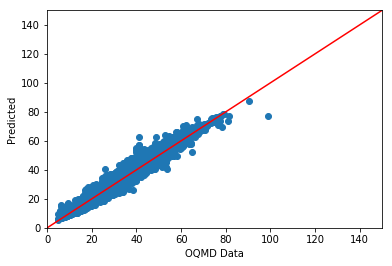

In [80]:
plt.scatter(volume_pa, rf_prediction)
plt.plot(range(0, 151), range(0, 151), 'r')
plt.axis([0, 150, 0, 150])
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

### Random Forest Regressor Error

In [81]:
cv_start = time.time()
errors = cross_val_score(RandomForestRegressor(), training_set_vol.drop(cols_to_drop, axis=1), volume_pa, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print(mae)
cv_time = time.time() - cv_start
print("Cross-validation time: ", cv_time)

2.1641771997
Cross-validation time:  255.22912883758545


### Decision Tree Regressor

In [82]:
dtr = DecisionTreeRegressor()
dtr.fit(training_set_vol.drop(cols_to_drop, axis=1), volume_pa)
dtr_prediction = dtr.predict(training_set_vol.drop(cols_to_drop, axis=1))

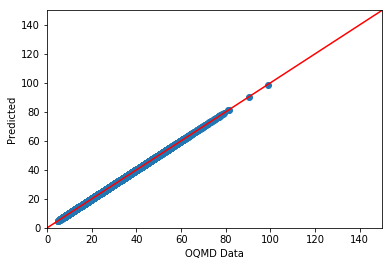

In [83]:
plt.scatter(volume_pa, dtr_prediction)
plt.plot(range(0, 151), range(0, 151), 'r')
plt.axis([0, 150, 0, 150])
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

### Support Vector Classification 80/20 split

In [84]:
X_train, X_test, y_train, y_test = train_test_split(training_set_vol.drop(cols_to_drop, axis=1), vol_range, test_size=0.2, random_state=0)

In [85]:
n_estimators = 10
clf = OneVsRestClassifier(BaggingClassifier(svm.SVC(kernel='linear', probability=True), max_samples=1.0 / n_estimators, n_estimators=n_estimators))

In [86]:
%%time
clf.fit(X_train, y_train)
print(clf.score(X_test,y_test))

0.910782172612
CPU times: user 19min 34s, sys: 14.2 s, total: 19min 48s
Wall time: 20min 15s


### KFold Cross Validation

In [87]:
%%time
scores = cross_val_score(clf, training_set_bg.drop(cols_to_drop, axis=1), vol_range, cv=3)

CPU times: user 45min 8s, sys: 28.1 s, total: 45min 36s
Wall time: 46min 20s


In [88]:
print("Accuracy %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Accuracy 0.86 (+/- 0.02)
